In [172]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [2]:
df = pd.read_csv("combined_energy_data.csv")

## Data Preprocessing

In [3]:
## convert it to datetime
df['datetime'] = pd.to_datetime(df.datetime)

In [4]:
agg_columns =  ["datetime","Wind"]
required_columns = ["Hours"] + agg_columns + [i for i in df.columns[12:]]

In [5]:
#the
df.datetime.min() , df.datetime.max()

(Timestamp('2016-12-31 23:00:00'), Timestamp('2020-07-16 21:45:00'))

In [6]:
df_agg = df[agg_columns].groupby([df.datetime.dt.floor("H")]).agg(["mean","median","max","min","std"])

In [7]:
df_agg.columns = df_agg.columns.map('_'.join)

In [8]:
df_agg = df_agg.reset_index()

In [9]:
df_agg.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std
0,2016-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0


In [10]:
df_merged = df_agg.merge(df[required_columns], how="left", on="datetime")

In [11]:
df_merged.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Hours,Wind,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2016-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,01:00,0.0,1.86,212.0,...,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,02:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,03:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,04:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_interpolated = df_merged.interpolate(method="linear")

In [13]:
df_interpolated = df_interpolated[2:]

## Feature selections through AR and PAR

In [14]:
import matplotlib.pyplot as plt
import seaborn as snn

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
## plot AR
def plot_auto_regression(data):
    fig , axs = plt.subplots(1,2,figsize=(20,8))
    lags = [30*24,90*24]

    for ax, lag in zip(axs.flatten(),lags):
        plot_acf(data,ax=ax, lags=lag)
    plt.plot()


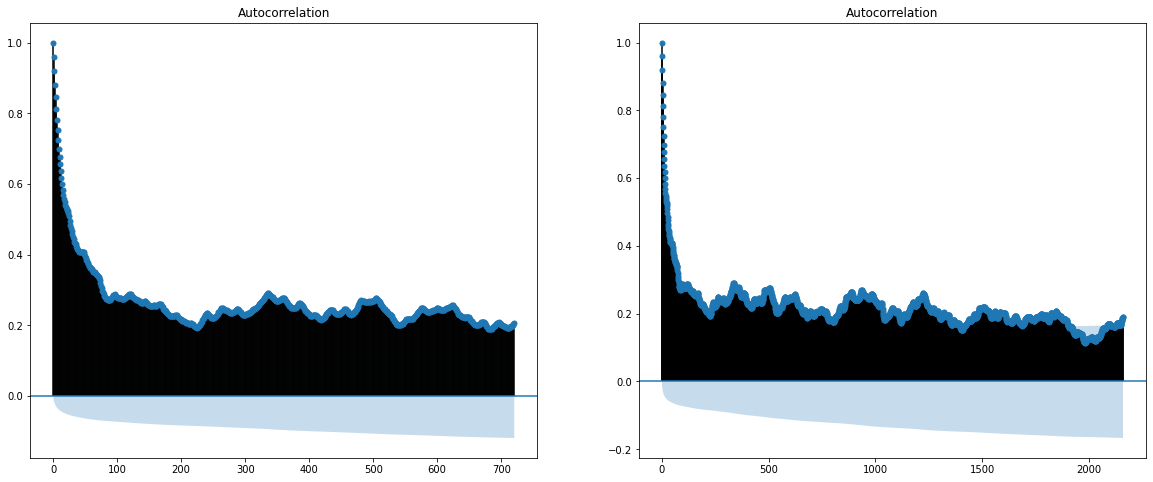

In [16]:
plot_auto_regression(df_interpolated.Wind)

In [17]:
hours_list = ["0{}:00".format(i)  for i in range(10)] + ["{}:00".format(i)  for i in range(10,25)]

In [18]:
useful_columns = df_interpolated.columns[1:]
print(useful_columns[:10])

Index(['Wind_mean', 'Wind_median', 'Wind_max', 'Wind_min', 'Wind_std', 'Hours',
       'Wind', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)'],
      dtype='object')


In [19]:
print(useful_columns[10:20])

Index(['lieusaint_Direction (deg N)', 'lvs-pussay_Speed(m/s)',
       'lvs-pussay_Direction (deg N)', 'parc-du-gatinais_Speed(m/s)',
       'parc-du-gatinais_Direction (deg N)', 'arville_Speed(m/s)',
       'arville_Direction (deg N)', 'boissy-la-riviere_Speed(m/s)',
       'boissy-la-riviere_Direction (deg N)', 'angerville-1_Speed(m/s)'],
      dtype='object')


In [20]:
print(useful_columns[20:30])

Index(['angerville-1_Direction (deg N)', 'angerville-2_Speed(m/s)',
       'angerville-2_Direction (deg N)', 'guitrancourt-b_Speed(m/s)',
       'guitrancourt-b_Direction (deg N)', 'lieusaint-b_Speed(m/s)',
       'lieusaint-b_Direction (deg N)', 'lvs-pussay-b_Speed(m/s)',
       'lvs-pussay-b_Direction (deg N)', 'parc-du-gatinais-b_Speed(m/s)'],
      dtype='object')


In [21]:
print(useful_columns[30:])

Index(['parc-du-gatinais-b_Direction (deg N)', 'arville-b_Speed(m/s)',
       'arville-b_Direction (deg N)', 'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)'],
      dtype='object')


In [22]:
def plot_all_acf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))

    for hour, ax in zip(hours_list, axs.flatten()):
            plot_acf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name], ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
            ax.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    plt.plot()
    
def plot_all_pacf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    
    for hour, ax in zip(hours_list, axs.flatten()):
            plot_pacf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name], ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
            ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    plt.plot()


## Model

In [89]:
normalized_df_wind_mean = (df_interpolated["Wind_mean"]-df_interpolated["Wind_mean"].mean())/df_interpolated["Wind_mean"].std()
def plot_diff_day_but_same_hour_ccf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    normalized_df_column = (df_interpolated[column_name]-df_interpolated[column_name].mean())/df_interpolated[column_name].std()
    for hour, ax in zip(hours_list, axs.flatten()):
            ax.xcorr(pd.Series(normalized_df_wind_mean)[df_interpolated.Hours==hour], pd.Series(normalized_df_column)[df_interpolated.Hours==hour], usevlines=True, maxlags=60, normed=True, lw=2 )
            ax.set_title('Cross-correlation hour {} with {}'.format(str(hour), column_name) )
            ax.grid(True)
            ax.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.full(100,-2),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
           
    plt.plot()

def plot_continuous_hour_ccf(column_name):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  
    normalized_df_column = (df_interpolated[column_name]-df_interpolated[column_name].mean())/df_interpolated[column_name].std()
    ax.xcorr(pd.Series(normalized_df_wind_mean), pd.Series(normalized_df_column), usevlines=True, maxlags=60, normed=True, lw=2 )
    ax.set_title('Cross-correlation with {}'.format( column_name) )
    ax.grid(True)
    plt.plot()
    plt.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
    plt.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
    plt.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    #plt.plot(np.full(100,18),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="orange")
  

In [149]:
import plotly.graph_objects as go

In [395]:
cross_correlation = np.correlate(pd.Series(normalized_df_wind_mean), pd.Series(normalized_df_column),"full")


NameError: name 'normalized_df_column' is not defined

In [406]:
def plot_diff_day_but_protect_eye(column_name):
    
    subtitle_name = (['Cross-correlation hour {} with {}'.format(str(hour), column_name)  for hour in hours_list])
   
    
    normalized_df_column = (df_interpolated[column_name]-df_interpolated[column_name].mean())/df_interpolated[column_name].std()
   
    fig = make_subplots(rows=24, cols=1 , subplot_titles=subtitle_name)
    for hour, i in zip(hours_list,range(1,25)):
        cross_correlation = np.correlate(pd.Series(normalized_df_wind_mean)[df_interpolated.Hours==hour], pd.Series(normalized_df_column)[df_interpolated.Hours==hour],"full")
        cross_shape = int(cross_correlation.shape[0]/2)
       
        y = cross_correlation[cross_shape-60:cross_shape+60]/10000
       
       
        
        
        fig.add_trace(go.Scatter(x=np.linspace(-60,60,120,dtype=np.int), y=y,mode="lines"),row=i, col=1)
        fig.add_trace(go.Scatter(x=np.linspace(-60,60,120), y=np.full(120,0.05), mode='lines'),row=i, col=1)
        fig.add_trace(go.Scatter((x=np.linspace(-60,60,120), y=np.full(120,-0.05), mode='lines'),row=i, col=1)
        fig.add_trace(x=np.full(100,-2), y=np.linspace(-0.1,0.1,100), mode='lines',row=i, col=1)
        fig.update_layout(height=9000, width=700,
                  title_text="Multiple Subplots with Titles")
        #print(i)
    fig.show()
            
 
    
def plot_continuous_hour_ccf_protect_eye(column_name):
    
    
    normalized_df_column = (df_interpolated[column_name]-df_interpolated[column_name].mean())/df_interpolated[column_name].std()
    
    cross_correlation = np.correlate(pd.Series(normalized_df_wind_mean), pd.Series(normalized_df_column),"full")
    #print(cross_correlation.shape)
    y = cross_correlation[31015-60:31015+60]/10000
    fig = px.line(x=np.linspace(-60,60,120,dtype=np.int), y=y)
    
    
    fig.add_scatter(x=np.linspace(-60,60,120), y=np.full(120,0.05), mode='lines')
    fig.add_scatter(x=np.linspace(-60,60,120), y=np.full(120,-0.05), mode='lines')
    fig.add_scatter(x=np.full(100,-30), y=np.linspace(-0.1,0.1,100), mode='lines')
   
    
    fig.layout.update(go.Layout(barmode = 'overlay',))

    #plotly.offline.plot(fig)
    fig.show()
   

In [407]:
plot_diff_day_but_protect_eye('lvs-pussay_Speed(m/s)')

TypeError: add_trace() got an unexpected keyword argument 'x'

In [333]:

             fig.add_trace(
                go.Scatter(x=np.linspace(-60,60,120), y=np.full(120,-0.05), mode='lines'),
                row=1,col=i
                )
           
                
            
            fig.add_trace(
                go.Scatter(x=np.full(100,-2), y=np.linspace(-0.1,0.1,100), mode='lines'),
                row=1,col=i
                )
            
            fig.add_trace(
                go.Scatter(x=np.linspace(-60,60,120), y=np.full(120,0.05), mode='lines'),
                row=1,col=i
                )

IndentationError: unexpected indent (<ipython-input-333-411ee518eed8>, line 8)

In [147]:
a = plot_continuous_hour_ccf_test('lvs-pussay_Speed(m/s)')

(62031,)


In [ ]:
def get_periodic_merge(period):
    dividants = np.linspace(0,df_interpolated.shape[0],df_interpolated.shape[0]/3,dtype=np.int)
    return 

In [ ]:
def get_convert_merge():
    return 

In [55]:

dividants = np.linspace(0,df_interpolated.shape[0],df_interpolated.shape[0]/3,dtype=np.int)

In [54]:
df_interpolated[dividants]

KeyError: "None of [Int64Index([    0,     3,     6,     9,    12,    15,    18,    21,    24,\n               27,\n            ...\n            30988, 30991, 30994, 30997, 31000, 31003, 31006, 31009, 31012,\n            31016],\n           dtype='int64', length=10338)] are in the [columns]"

In [58]:
dividants

array([    0,     3,     6, ..., 31009, 31012, 31016])

In [70]:
df_interpolated.reset_index(drop_)

,index,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Hours,Wind,guitrancourt_Speed(m/s),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,02:00,0.0,1.961667,...,2.505000,221.333333,2.516667,221.333333,2.723333,221.833333,2.72,223.500000,2.720000,223.500000
1,3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,03:00,0.0,2.063333,...,2.500000,217.666667,2.513333,217.666667,2.716667,217.666667,2.70,219.000000,2.700000,219.000000
2,4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,04:00,0.0,2.165000,...,2.495000,214.000000,2.510000,214.000000,2.710000,213.500000,2.68,214.500000,2.680000,214.500000
3,5,2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,05:00,0.0,2.266667,...,2.490000,210.333333,2.506667,210.333333,2.703333,209.333333,2.66,210.000000,2.660000,210.000000
4,6,2017-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,06:00,0.0,2.368333,...,2.485000,206.666667,2.503333,206.666667,2.696667,205.166667,2.64,205.500000,2.640000,205.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31011,31013,2020-07-16 17:00:00,1750.0,1750.0,1750.0,1750.0,0.0,19:00,1750.0,2.863333,...,3.253333,339.333333,3.310000,339.666667,3.770000,348.000000,3.77,350.666667,3.773333,350.666667
31012,31014,2020-07-16 18:00:00,1750.0,1750.0,1750.0,1750.0,0.0,20:00,1750.0,2.840000,...,3.570000,350.000000,3.570000,349.000000,3.420000,353.000000,3.46,357.000000,3.460000,357.000000
31013,31015,2020-07-16 19:00:00,1750.0,1750.0,1750.0,1750.0,0.0,21:00,1750.0,2.923333,...,3.436667,351.333333,3.436667,350.666667,3.363333,352.333333,3.39,355.666667,3.390000,355.666667
31014,31016,2020-07-16 20:00:00,1750.0,1750.0,1750.0,1750.0,0.0,22:00,1750.0,3.006667,...,3.303333,352.666667,3.303333,352.333333,3.306667,351.666667,3.32,354.333333,3.320000,354.333333
